In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(911)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
df = pd.read_csv('csv/treinamento.csv', parse_dates=['Data'])

In [3]:
df

,Rodada,Data,Sem,Edicao,Casa,Visitante,Nacionalidade Casa,Nacionalidade Visitante,Resultado,Gols Casa,Gols Visitante
0,Fase de Grupos,2014-01-28,1.0,2014,Oriente Petrolero,Nacional,bo,uy,1,1,0
1,Fase de Grupos,2014-01-28,1.0,2014,Morelia,Santa Fe,mx,co,1,2,1
2,Fase de Grupos,2014-01-29,1.0,2014,Sporting Cristal,Atl Paranaense,pe,br,1,2,1
3,Fase de Grupos,2014-01-29,1.0,2014,SD Quito,Botafogo (RJ),ec,br,1,1,0
4,Fase de Grupos,2014-01-30,1.0,2014,Univ Chile,Guaraní,cl,py,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1252,Fase de Grupos,2023-06-28,6.0,2023,Flamengo,SD Aucas,br,ec,1,4,0
1253,Fase de Grupos,2023-06-28,6.0,2023,Corinthians,Liverpool,br,uy,1,3,0
1254,Fase de Grupos,2023-06-28,6.0,2023,Racing Club,Ñublense,ar,cl,1,4,0
1255,Fase de Grupos,2023-06-29,6.0,2023,Barcelona SC,Cerro Porteño,ec,py,0,2,2


------
# Feature Engineering
+ Criação de novas features
+ Transformação de features categóricas
+ Seleção das features


------
## Mas antes, train-test split

<Axes: xlabel='Resultado'>

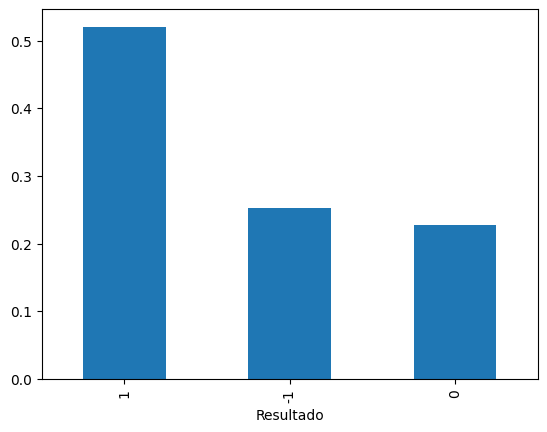

In [4]:
df["Resultado"].value_counts(normalize=True).plot(kind='bar')

#### Como nossa variável resposta, *Resultado*, não é desbalanceada demais, vamos seguir sem nenhum tratamento específico para esse tipo de situação.

#### Outro ponto **importante**, temos 3 tipos possivéis de resultados: vitória, empate e derrota. Por enquanto vamos manter assim apenas com 2 possibilidades: vitória ou qualquer outro resultado.

In [5]:
df["Edicao"].unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
      dtype=int64)

### Vamos usar as edições de 2014 até 2020 para treinar os modelos e depois vamos testar para as de 2021 e 2022

In [6]:
train_eds = [2014, 2015, 2016, 2017, 2018, 2019, 2020]
test_eds = [2021, 2022]

train = df.loc[df["Edicao"].isin(train_eds)]
test = df.loc[df["Edicao"].isin(test_eds)]

----------

In [7]:
train

,Rodada,Data,Sem,Edicao,Casa,Visitante,Nacionalidade Casa,Nacionalidade Visitante,Resultado,Gols Casa,Gols Visitante
0,Fase de Grupos,2014-01-28,1.0,2014,Oriente Petrolero,Nacional,bo,uy,1,1,0
1,Fase de Grupos,2014-01-28,1.0,2014,Morelia,Santa Fe,mx,co,1,2,1
2,Fase de Grupos,2014-01-29,1.0,2014,Sporting Cristal,Atl Paranaense,pe,br,1,2,1
3,Fase de Grupos,2014-01-29,1.0,2014,SD Quito,Botafogo (RJ),ec,br,1,1,0
4,Fase de Grupos,2014-01-30,1.0,2014,Univ Chile,Guaraní,cl,py,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
901,Quartas de final,2020-12-16,NaN,2020,Santos,Grêmio,br,br,1,4,1
902,Quartas de final,2020-12-15,NaN,2020,Palmeiras,Libertad,br,py,1,3,0
903,Quartas de final,2020-12-16,NaN,2020,Racing Club,Boca Juniors,ar,ar,1,1,0
904,Quartas de final,2020-12-17,NaN,2020,Nacional,River Plate,uy,ar,-1,2,6


--------
## Criação de features
+ Número acumulado de gols feitos na competição
+ Número acumulado de gols tomados na competição
+ Vitórias, empates e derrotas na edição (jogando em Casa & Visitante)
+ Mata-mata: resultado do primeiro jogo

--------
### Número acumulado de gols 

In [8]:
def cria_variaveis_gols(dset):
    ds = dset.copy()
    edicoes = ds["Edicao"].unique() # pegando todas edicoes dos dados

    for edicao in edicoes: # para cada edicao
        times_participantes = ds[ds["Edicao"] == edicao]["Casa"].unique() # times participantes de tal edicao

        for time in times_participantes: # para cada time em cada edicao
            # acumulado gols feitos em casa
            ds.loc[(ds["Edicao"] == edicao) & (ds["Casa"] == time), "Acum Gols Casa"] = ds.loc[
                (ds["Edicao"] == edicao) & (ds["Casa"] == time), "Gols Casa"
                ].cumsum().shift()

            # acumulado gols levados em casa
            ds.loc[(ds["Edicao"] == edicao) & (ds["Casa"] == time), "Acum Gols Lev. Casa"] = ds.loc[
                (ds["Edicao"] == edicao) & (ds["Casa"] == time), "Gols Visitante"
                ].cumsum().shift()

            # acumulado gols feitos fora de casa
            ds.loc[(ds["Edicao"] == edicao) & (ds["Visitante"] == time), "Acum Gols Visitante"] = ds.loc[
                (ds["Edicao"] == edicao) & (ds["Visitante"] == time), "Gols Visitante"
                ].cumsum().shift()

            # acumulado gols levados fora de casa
            ds.loc[(ds["Edicao"] == edicao) & (ds["Visitante"] == time), "Acum Gols Lev. Visitante"] = ds.loc[
                (ds["Edicao"] == edicao) & (ds["Visitante"] == time), "Gols Casa"
                ].cumsum().shift()

            '''
            Por conta de criar uma linha nula para jogar em casa e jogar fora, todo segundo jogo de cada time estavam com as informações erradas.
            Para atualizar, vamos puxar as infos do jogo 1, e nunca os dois primeiros jogos são jogados em seguida casa nem em seguida como visitante,
            vamos pegar informações "cruzadas".
            '''
            
            aux = ds[(ds["Edicao"] == edicao) & ((ds["Casa"] == time) | (ds["Visitante"] == time))]
            
            if aux.iloc[0]["Casa"] == time:
                # atualizando gols feitos
                ds.loc[aux.index[1], "Acum Gols Visitante"] =  ds.loc[aux.index[0], "Gols Casa"]
                # atualizando gols sofridos
                ds.loc[aux.index[1], "Acum Gols Lev. Visitante"] = ds.loc[aux.index[0], "Gols Visitante"]
            else:
                # atualizando gols feitos
                ds.loc[aux.index[1], "Acum Gols Casa"] =  ds.loc[aux.index[0], "Gols Visitante"]
                # atualizando gols sofridos
                ds.loc[aux.index[1], "Acum Gols Lev. Casa"] = ds.loc[aux.index[0], "Gols Casa"]

    ds[["Acum Gols Casa", "Acum Gols Lev. Casa", "Acum Gols Visitante",  "Acum Gols Lev. Visitante"]] = \
    ds[["Acum Gols Casa", "Acum Gols Lev. Casa", "Acum Gols Visitante", "Acum Gols Lev. Visitante"]].fillna(value=0)
    
    return ds

In [9]:
def cria_variaveis_gols(dset):
    ds = dset.copy()
    edicoes = ds["Edicao"].unique() # pegando todas edicoes dos dados
    
    for edicao in edicoes: # para cada edicao
        times_participantes = ds[ds["Edicao"] == edicao]["Casa"].unique() # times participantes de tal edicao

        for time in times_participantes: # para cada time em cada edicao

            ''' Jogando em casa '''
            jogando_em_casa = ds.loc[(ds["Edicao"]== edicao) & (ds["Casa"]== time)]
            indexs = jogando_em_casa.index
            for i in range(len(jogando_em_casa)):
                if i == 0:
                    ds.loc[indexs[0], ['Acum Gols Casa', 'Acum Gols Lev. Casa']] = 0
                else:
                    ds.loc[indexs[i], 'Acum Gols Casa'] = ds.loc[indexs[i-1], 'Gols Casa'] +  ds.loc[indexs[i-1], 'Acum Gols Casa']
                    ds.loc[indexs[i], 'Acum Gols Lev. Casa'] = ds.loc[indexs[i-1], 'Gols Visitante'] +  ds.loc[indexs[i-1], 'Acum Gols Lev. Casa']

            ''' Jogando fora '''
            jogando_fora_de_casa = ds.loc[(ds["Edicao"]== edicao) & ((ds["Visitante"]== time))]
            indexs = jogando_fora_de_casa.index
            for i in range(len(jogando_fora_de_casa)):
                if i == 0:
                    ds.loc[indexs[0], ['Acum Gols Visitante', 'Acum Gols Lev. Visitante']] = 0
                else:
                    ds.loc[indexs[i], 'Acum Gols Visitante'] = ds.loc[indexs[i-1], 'Gols Visitante'] + ds.loc[indexs[i-1], 'Acum Gols Visitante']
                    ds.loc[indexs[i], 'Acum Gols Lev. Visitante'] = ds.loc[indexs[i-1], 'Gols Casa'] + ds.loc[indexs[i-1], 'Acum Gols Lev. Visitante']
            
    return ds

In [10]:
train_new_feats = cria_variaveis_gols(train)

In [11]:
train_new_feats.loc[(train_new_feats["Edicao"].isin([2017])) & ((train_new_feats["Casa"] == 'River Plate') | (train_new_feats["Visitante"] == 'River Plate'))]

,Rodada,Data,Sem,Edicao,Casa,Visitante,Nacionalidade Casa,Nacionalidade Visitante,Resultado,Gols Casa,Gols Visitante,Acum Gols Casa,Acum Gols Lev. Casa,Acum Gols Visitante,Acum Gols Lev. Visitante
428,Fase de Grupos,2017-03-15,1.0,2017,Independiente,River Plate,co,ar,-1,1,3,0.0,0.0,0.0,0.0
446,Fase de Grupos,2017-04-13,2.0,2017,River Plate,Melgar,ar,pe,1,4,2,0.0,0.0,0.0,0.0
467,Fase de Grupos,2017-04-27,3.0,2017,CS Emelec,River Plate,ec,ar,-1,1,2,1.0,0.0,3.0,1.0
482,Fase de Grupos,2017-05-10,4.0,2017,River Plate,CS Emelec,ar,ec,0,1,1,4.0,2.0,0.0,1.0
493,Fase de Grupos,2017-05-18,5.0,2017,Melgar,River Plate,pe,ar,-1,2,3,2.0,2.0,5.0,2.0
500,Fase de Grupos,2017-05-25,6.0,2017,River Plate,Independiente,ar,co,-1,1,2,5.0,3.0,2.0,2.0
509,Oitavas de final,2017-07-04,NaN,2017,Guaraní,River Plate,py,ar,-1,0,2,4.0,2.0,8.0,4.0
517,Oitavas de final,2017-08-08,NaN,2017,River Plate,Guaraní,ar,py,0,1,1,6.0,5.0,5.0,5.0
526,Quartas de final,2017-09-14,NaN,2017,Wilstermann,River Plate,bo,ar,1,3,0,12.0,5.0,10.0,4.0
527,Quartas de final,2017-09-21,NaN,2017,River Plate,Wilstermann,ar,bo,1,8,0,7.0,6.0,1.0,5.0


#### Show, agora já temos 4 novas variáveis que possivelmente irá explicar em uma parte os resultados.

#### Como as variáveis gols casa e gols visitantes só são coletadas após o final do jogo, da mesma forma que o resultado, entâo são variáveis que para nossa modelagem não faz sentido, portanto vamos removê-las. 
Obs: Em Ciência de Dados esse fenômeno é chamado de Data Drift.

In [12]:
train_new_feats = train_new_feats.drop(columns=["Gols Casa", "Gols Visitante"])

---------
### Vitórias, empates e derrotas na edição

In [13]:
def cria_variaveis_resultados_competicao(dset):
    ds = dset.copy()
    edicoes = ds["Edicao"].unique() # pegando todas edicoes dos dados
    
    for edicao in edicoes: # para cada edicao
        times_participantes = ds[ds["Edicao"] == edicao]["Casa"].unique() # times participantes de tal edicao
        for time in times_participantes:
            # vitórias acumuladas casa
            vc = ds[(ds["Edicao"] == edicao) & (ds["Casa"] == time) & (ds["Resultado"] == 1)]
            ds.loc[vc.index, 'Vitorias Casa'] = np.arange(vc.shape[0])
            # vitórias acumuladas visitante
            vv = ds[(ds["Edicao"] == edicao) & (ds["Visitante"] == time) & (ds["Resultado"] == -1)]
            ds.loc[vv.index, 'Vitorias Visitante'] = np.arange(vv.shape[0])
            
            # empates acumuladas casa
            ec = ds[(ds["Edicao"] == edicao) & (ds["Casa"] == time) & (ds["Resultado"] == 0)]
            ds.loc[ec.index, 'Empates Casa'] = np.arange(ec.shape[0])
            # empates acumuladas visitante
            ev = ds[(ds["Edicao"] == edicao) & (ds["Visitante"] == time) & (ds["Resultado"] == 0)]
            ds.loc[ev.index, 'Empates Visitante'] = np.arange(ev.shape[0])
            
            # derrotas acumuladas casa
            dc = ds[(ds["Edicao"] == edicao) & (ds["Casa"] == time) & (ds["Resultado"] == -1)]
            ds.loc[dc.index, 'Derrotas Casa'] = np.arange(dc.shape[0])
            # derrotas acumuladas visitante
            dv = ds[(ds["Edicao"] == edicao) & (ds["Visitante"] == time) & (ds["Resultado"] == 1)]
            ds.loc[dv.index, 'Derrotas Visitante'] = np.arange(dv.shape[0])

            # arrastando resultados para preencher nulos
            # ds.loc[(ds["Edicao"] == edicao) & (ds["Casa"] == time), ['Vitorias Casa', 'Empates Casa', 'Derrotas Casa']] =\
            # ds.loc[(ds["Edicao"] == edicao) & (ds["Casa"] == time), ['Vitorias Casa', 'Empates Casa', 'Derrotas Casa']].fillna(method='bfill')
            
            # ds.loc[(ds["Edicao"] == edicao) & (ds["Visitante"] == time), ['Vitorias Visitante', 'Empates Visitante', 'Derrotas Visitante']] =\
            # ds.loc[(ds["Edicao"] == edicao) & (ds["Visitante"] == time), ['Vitorias Visitante', 'Empates Visitante', 'Derrotas Visitante']].fillna(method='bfill')

            # Pro futuro completamos os faltantes com os últimos valores observados
            ds.loc[(ds["Edicao"] == edicao) & (ds["Casa"] == time), ['Vitorias Casa', 'Empates Casa', 'Derrotas Casa']] =\
            ds.loc[(ds["Edicao"] == edicao) & (ds["Casa"] == time), ['Vitorias Casa', 'Empates Casa', 'Derrotas Casa']].ffill()
            
            ds.loc[(ds["Edicao"] == edicao) & (ds["Visitante"] == time), ['Vitorias Visitante', 'Empates Visitante', 'Derrotas Visitante']] =\
            ds.loc[(ds["Edicao"] == edicao) & (ds["Visitante"] == time), ['Vitorias Visitante', 'Empates Visitante', 'Derrotas Visitante']].ffill()
            
        # Pro passado completamos os faltantes com nulos - o que não ocorreu, ex: time não empatou nenhum jogo
        # ds.loc[:, ['Vitorias Casa', 'Empates Casa', 'Derrotas Casa', 'Vitorias Visitante', 'Empates Visitante', 'Derrotas Visitante']] = \
        # ds.loc[:, ['Vitorias Casa', 'Empates Casa', 'Derrotas Casa', 'Vitorias Visitante', 'Empates Visitante', 'Derrotas Visitante']].fillna(value=0)


            
    return ds

In [14]:
def cria_variaveis_resultados_competicao(dset):
    ds = dset.copy()
    edicoes = ds["Edicao"].unique() # pegando todas edicoes dos dados
    
    for edicao in edicoes: # para cada edicao
        times_participantes = ds[ds["Edicao"] == edicao]["Casa"].unique() # times participantes de tal edicao

        for time in times_participantes: # para cada time em cada edicao

            ''' Jogando em casa '''
            jogando_em_casa = ds.loc[(ds["Edicao"]== edicao) & ((ds["Casa"]== time))]
            indexs = jogando_em_casa.index
            for i in range(len(jogando_em_casa)):
                if i == 0:
                    ds.loc[indexs[0], ['Vitorias Casa', 'Empates Casa', 'Derrotas Casa']] = 0
                else:
                    resultado_aux = jogando_em_casa.loc[indexs[i-1], 'Resultado'] # resultado do último jogo
                    ds.loc[indexs[i], 'Vitorias Casa'] = ds.loc[indexs[i-1], 'Vitorias Casa'] + 1 if resultado_aux == 1 else ds.loc[indexs[i-1], 'Vitorias Casa']
                    ds.loc[indexs[i], 'Empates Casa'] = ds.loc[indexs[i-1], 'Empates Casa'] + 1 if resultado_aux == 0 else ds.loc[indexs[i-1], 'Empates Casa']
                    ds.loc[indexs[i], 'Derrotas Casa'] = ds.loc[indexs[i-1], 'Derrotas Casa'] + 1 if resultado_aux == -1 else ds.loc[indexs[i-1], 'Derrotas Casa']

            ''' Jogando fora '''
            jogando_fora_de_casa = ds.loc[(ds["Edicao"]== edicao) & ((ds["Visitante"]== time))]
            indexs = jogando_fora_de_casa.index
            for i in range(len(jogando_fora_de_casa)):
                if i == 0:
                    ds.loc[indexs[0], ['Vitorias Visitante', 'Empates Visitante', 'Derrotas Visitante']] = 0
                else:
                    resultado_aux = jogando_fora_de_casa.loc[indexs[i-1], 'Resultado'] # resultado do último jogo
                    ds.loc[indexs[i], 'Vitorias Visitante'] = ds.loc[indexs[i-1], 'Vitorias Visitante'] + 1 if resultado_aux == -1 else ds.loc[indexs[i-1], 'Vitorias Visitante']
                    ds.loc[indexs[i], 'Empates Visitante'] = ds.loc[indexs[i-1], 'Empates Visitante'] + 1 if resultado_aux == 0 else ds.loc[indexs[i-1], 'Empates Visitante']
                    ds.loc[indexs[i], 'Derrotas Visitante'] = ds.loc[indexs[i-1], 'Derrotas Visitante'] + 1 if resultado_aux == 1 else ds.loc[indexs[i-1], 'Derrotas Visitante']
            
    return ds

In [15]:
train_new_feats2 = cria_variaveis_resultados_competicao(train_new_feats)

In [16]:
edicao =2018
time = 'Palmeiras'
ds = train_new_feats.copy()

jogando_fora_de_casa = ds.loc[(ds["Edicao"]== edicao) & ((ds["Visitante"]== time))]
indexs = jogando_fora_de_casa.index
for i in range(len(jogando_fora_de_casa)):
    if i == 0:
        ds.loc[indexs[0], ['Vitorias Visitante', 'Empates Visitante', 'Derrotas Visitante']] = 0
    else:
        resultado_aux = jogando_fora_de_casa.loc[indexs[i-1], 'Resultado'] # resultado do último jogo
        ds.loc[indexs[i], 'Vitorias Visitante'] = ds.loc[indexs[i-1], 'Vitorias Visitante'] + 1 if resultado_aux == -1 else ds.loc[indexs[i-1], 'Vitorias Visitante']
        ds.loc[indexs[i], 'Empates Visitante'] = ds.loc[indexs[i-1], 'Empates Visitante'] + 1 if resultado_aux == 0 else ds.loc[indexs[i-1], 'Empates Visitante']
        ds.loc[indexs[i], 'Derrotas Visitante'] = ds.loc[indexs[i-1], 'Derrotas Visitante'] + 1 if resultado_aux == 1 else ds.loc[indexs[i-1], 'Derrotas Visitante']

In [17]:
train_new_feats2.loc[(train_new_feats2["Edicao"].isin([2018])) & ((train_new_feats2["Casa"] == 'Palmeiras') | (train_new_feats2["Visitante"] == 'Palmeiras'))]

,Rodada,Data,Sem,Edicao,Casa,Visitante,Nacionalidade Casa,Nacionalidade Visitante,Resultado,Acum Gols Casa,Acum Gols Lev. Casa,Acum Gols Visitante,Acum Gols Lev. Visitante,Vitorias Casa,Empates Casa,Derrotas Casa,Vitorias Visitante,Empates Visitante,Derrotas Visitante
548,Fase de Grupos,2018-03-01,1.0,2018,Junior,Palmeiras,co,br,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
565,Fase de Grupos,2018-04-03,2.0,2018,Palmeiras,Alianza Lima,br,pe,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
572,Fase de Grupos,2018-04-11,3.0,2018,Palmeiras,Boca Juniors,br,ar,0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
593,Fase de Grupos,2018-04-25,4.0,2018,Boca Juniors,Palmeiras,ar,br,-1,1.0,0.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
606,Fase de Grupos,2018-05-03,5.0,2018,Alianza Lima,Palmeiras,pe,br,-1,0.0,2.0,5.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0
617,Fase de Grupos,2018-05-16,6.0,2018,Palmeiras,Junior,br,co,1,3.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
637,Oitavas de final,2018-08-09,NaN,2018,Cerro Porteño,Palmeiras,py,br,-1,5.0,3.0,8.0,1.0,2.0,1.0,0.0,3.0,0.0,0.0
647,Oitavas de final,2018-08-30,NaN,2018,Palmeiras,Cerro Porteño,br,py,-1,6.0,2.0,3.0,5.0,2.0,1.0,0.0,2.0,0.0,1.0
651,Quartas de final,2018-09-20,NaN,2018,Colo-Colo,Palmeiras,cl,br,-1,3.0,3.0,10.0,1.0,2.0,0.0,2.0,4.0,0.0,0.0
654,Quartas de final,2018-10-03,NaN,2018,Palmeiras,Colo-Colo,br,cl,1,6.0,3.0,4.0,4.0,2.0,1.0,1.0,1.0,2.0,1.0


-----
## Encoders

In [18]:
train_all_feats = train_new_feats2.copy() # salvando uma cópia

In [19]:
print('Total de times participantes da Libertadores desde 2014')
train_all_feats["Casa"].nunique()

Total de times participantes da Libertadores desde 2014


91

Aplicar o *one-hot-encoder* aqui não será uma boa ideia por conta do número de colunas que serão criadas, então vamos tentar com o *label encoder*. Mas não intuitivamente acabamos por criar uma "hierarquia" e já que isso vai ocorrer vamos tentar ajustar para que faça um pouco de sentido.

Podemos tentar reduzir o número de encoders a serem criados, assumindo que times com apenas uma participação serão considerados todos como "estreante".

Vamos bucar quantas vezes ocorreu de apenas um time participar da Libertadores.

In [20]:
times_por_edicao = train_all_feats.groupby("Edicao")["Casa"].unique()
times_por_edicao

Edicao
2014    [Oriente Petrolero, Morelia, Sporting Cristal,...
2015    [Alianza Lima, Morelia, Palestino, Dep Táchira...
2016    [CA Huracán, U César Vallejo, River Plate, Ind...
2017    [Iquique, Wilstermann, Sport Boys, Godoy Cruz,...
2018    [Monagas, Defensor, Nacional, Racing Club, Col...
2019    [Melgar, San José, Godoy Cruz, Palestino, Atlé...
2020    [Internacional, Defensa y Just, Barcelona SC, ...
Name: Casa, dtype: object

In [21]:
times_por_edicao.apply(lambda x: len(x))

Edicao
2014    36
2015    37
2016    36
2017    31
2018    31
2019    32
2020    31
Name: Casa, dtype: int64

In [22]:
todos_times = train_all_feats["Casa"].unique()

contagem_participacoes = dict()
for time in todos_times: # para cada time
    c = 0 # iniciamos o contador
    for ed in times_por_edicao: # e passamos para cada edição
        if time in ed: # validando se o time participou
            c += 1 # e somando uma participação se o caso for sim
    contagem_participacoes[time] = c

In [23]:
# to pandas series
contagem_participacoes_pd = pd.Series(contagem_participacoes)
estreantes = contagem_participacoes_pd[contagem_participacoes_pd == 1]
veteranos = contagem_participacoes_pd[contagem_participacoes_pd > 1]

In [24]:
print(f'times com apenas 1 participação na libertadores: {len(estreantes)}')
print(f'times com mais de 1 participação na libertadores: {len(veteranos)}')

times com apenas 1 participação na libertadores: 36
times com mais de 1 participação na libertadores: 55


In [25]:
veteranos.sort_values()[-20:]

Bolívar             4
Santos              4
Zamora              4
Sporting Cristal    5
Santa Fe            5
Guaraní             5
Palmeiras           5
Atlético Mineiro    5
Flamengo            5
Boca Juniors        5
The Strongest       5
Libertad            5
Cerro Porteño       5
San Lorenzo         5
CS Emelec           6
Peñarol             6
Grêmio              6
Independiente       6
River Plate         6
Nacional            7
dtype: int64

Olhando o número de categorias que criamos [1,2,3,4,5,6,7] a partir do número de participações na libertadores, acredito que realizar esse "de para" como nosso encoder, já irá funcionar relativamente bem.

In [26]:
contagem_participacoes

{'Oriente Petrolero': 2,
 'Morelia': 2,
 'Sporting Cristal': 5,
 'SD Quito': 1,
 'Univ Chile': 4,
 'Caracas FC': 1,
 'Nacional': 7,
 'Santa Fe': 5,
 'Guaraní': 5,
 'Botafogo (RJ)': 2,
 'Atl Paranaense': 4,
 'Lanús': 2,
 'Anzoátegui': 1,
 'Santos': 4,
 'Zamora': 4,
 'Universitario': 2,
 'León': 1,
 'Real Garcilaso': 2,
 'AD Cali': 2,
 'CS Emelec': 6,
 'Independiente': 6,
 'Defensor': 2,
 'Peñarol': 6,
 'Bolívar': 4,
 "O'Higgins": 1,
 'The Strongest': 5,
 'Cruzeiro': 4,
 'Vélez Sarsf': 1,
 'Cerro Porteño': 5,
 'Unión Española': 1,
 'Arsenal': 1,
 'Grêmio': 6,
 'San Lorenzo': 5,
 'Atlético Mineiro': 5,
 'Flamengo': 5,
 "Newell's OB": 1,
 'Alianza Lima': 4,
 'Palestino': 2,
 'Dep Táchira': 2,
 'Corinthians': 3,
 'CA Huracán': 3,
 'Once Caldas': 1,
 'Estudiantes': 3,
 'Wanderers': 1,
 'Atlas': 1,
 'Libertad': 5,
 'UANL': 1,
 'Danubio': 1,
 'Colo-Colo': 4,
 'San José': 2,
 'Racing Club': 4,
 'Internacional': 3,
 'Boca Juniors': 5,
 'São Paulo': 3,
 'Barcelona SC': 3,
 'Mineros': 1,
 'River P

### Criando uma classe para realizar essa função

In [27]:
class MeuEncoder(BaseEstimator, TransformerMixin):
    """
    Classe responsável para aplicar encoder nas variáveis que representam os times conforme número de participações na libertadores.

    Parametros
    ----------
    X : pandas dataframe
        Variáveis para definir encoder.

    Retornos
    --------
    x_transformed : pandas series
        Variável com encoder aplicado.
    """

    def __init__(self):
        self

    def fit(self, X):  
        self.todos_times_ = X["Casa"].unique() # todos os times
        self.times_por_edicao_ = X.groupby("Edicao")["Casa"].unique() # todos times que jogaram por edicao
        self.contagem_participacoes_ = dict() # onde vamos armazenar o encoder
        
        for time in self.todos_times_: # para cada time
            c = 0 # iniciamos o contador
            for ed in self.times_por_edicao_: # e passamos para cada edição
                if time in ed: # validando se o time participou
                    c += 1 # e somando uma participação se o caso for sim
            self.contagem_participacoes_[time] = c

        return self

    def transform(self, x):
        check_is_fitted(self)
        x_transformed = x.map(self.contagem_participacoes_)
        x_transformed = x_transformed.fillna(1)
        
        return x_transformed

In [28]:
encoder = MeuEncoder()
encoder.fit(train_all_feats)

MeuEncoder()

In [29]:
encoder.times_por_edicao_

Edicao
2014    [Oriente Petrolero, Morelia, Sporting Cristal,...
2015    [Alianza Lima, Morelia, Palestino, Dep Táchira...
2016    [CA Huracán, U César Vallejo, River Plate, Ind...
2017    [Iquique, Wilstermann, Sport Boys, Godoy Cruz,...
2018    [Monagas, Defensor, Nacional, Racing Club, Col...
2019    [Melgar, San José, Godoy Cruz, Palestino, Atlé...
2020    [Internacional, Defensa y Just, Barcelona SC, ...
Name: Casa, dtype: object

In [30]:
train_all_feats["Senioridade Casa"] = encoder.transform(train_all_feats["Casa"])
train_all_feats["Senioridade Visitante"] = encoder.transform(train_all_feats["Visitante"])

In [31]:
train_all_feats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 906 entries, 0 to 905
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Rodada                    906 non-null    object        
 1   Data                      906 non-null    datetime64[ns]
 2   Sem                       708 non-null    float64       
 3   Edicao                    906 non-null    int64         
 4   Casa                      906 non-null    object        
 5   Visitante                 906 non-null    object        
 6   Nacionalidade Casa        906 non-null    object        
 7   Nacionalidade Visitante   906 non-null    object        
 8   Resultado                 906 non-null    int64         
 9   Acum Gols Casa            906 non-null    float64       
 10  Acum Gols Lev. Casa       906 non-null    float64       
 11  Acum Gols Visitante       906 non-null    float64       
 12  Acum Gols Lev. Visitante  9

### Encoder para a rodada

In [32]:
train_all_feats["Rodada"].unique()

array(['Fase de Grupos', 'Oitavas de final', 'Quartas de final',
       'Semifinais', 'Final'], dtype=object)

In [33]:
encod_rodada = {'Fase de Grupos': 0,
               'Oitavas de final': 1,
                'Quartas de final': 2,
               'Semifinais': 3,
               'Final': 4}

train_all_feats["Enc Rodada"] = train_all_feats["Rodada"].map(encod_rodada)

--------
## Seleção de Features

### Por enquanto, vamos seguir sem as vriáveis categóricas de nacionalidades dos times, rodada e nomes dos times; também vamos excluir a coluna "Sem"

In [34]:
train_to_select = train_all_feats.drop(columns=["Rodada", "Sem", "Nacionalidade Casa", "Nacionalidade Visitante", "Casa", "Visitante"])

# separando features de target
Xtrain = train_to_select.drop(columns="Resultado")
ytrain = train_to_select["Resultado"]

### Corrrelação

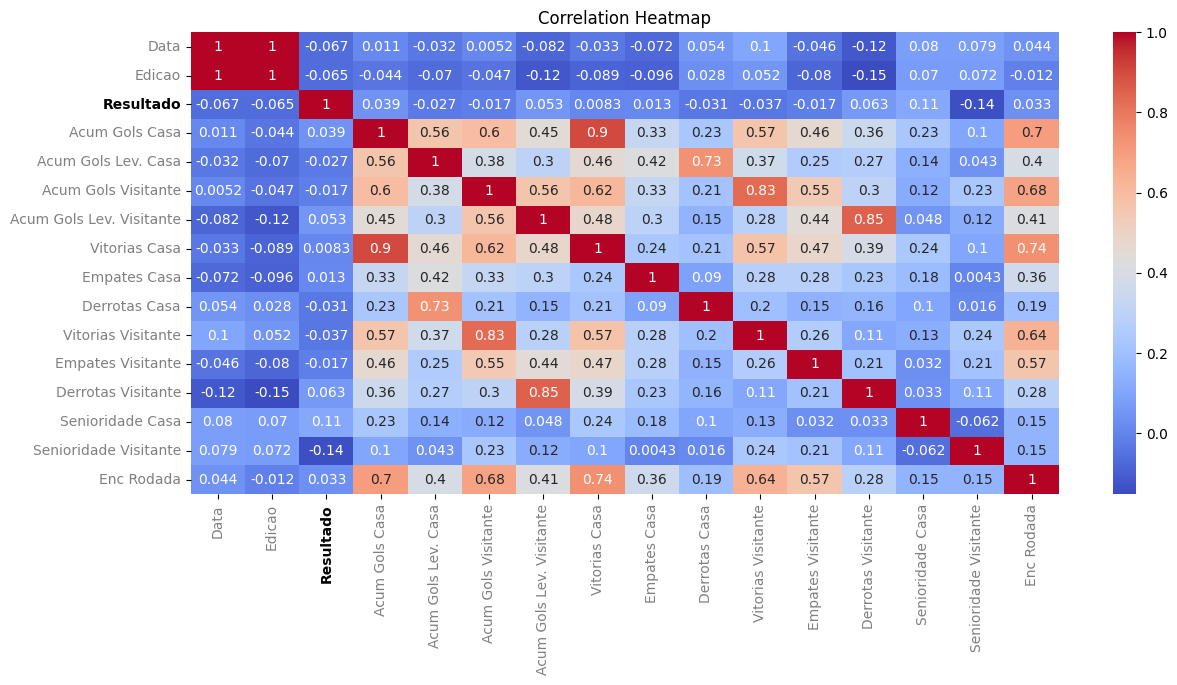

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular a correlação
correlation = train_to_select.corr()

# Cria um gráfico de calor
plt.figure(figsize=(14, 6))
ax = sns.heatmap(correlation, cmap='coolwarm', annot=True)

# Obter os rótulos dos eixos
labels = ax.get_xticklabels() + ax.get_yticklabels()

# Iterar sobre os rótulos e adicionar negrito aos que correspondem a 'Resultado'
for label in labels:
    text = label.get_text()
    if text == 'Resultado':
        label.set_weight('bold')
        label.set_color('black')
    else:
        label.set_weight('normal')
        label.set_color('gray')

plt.title('Correlation Heatmap')
plt.show()

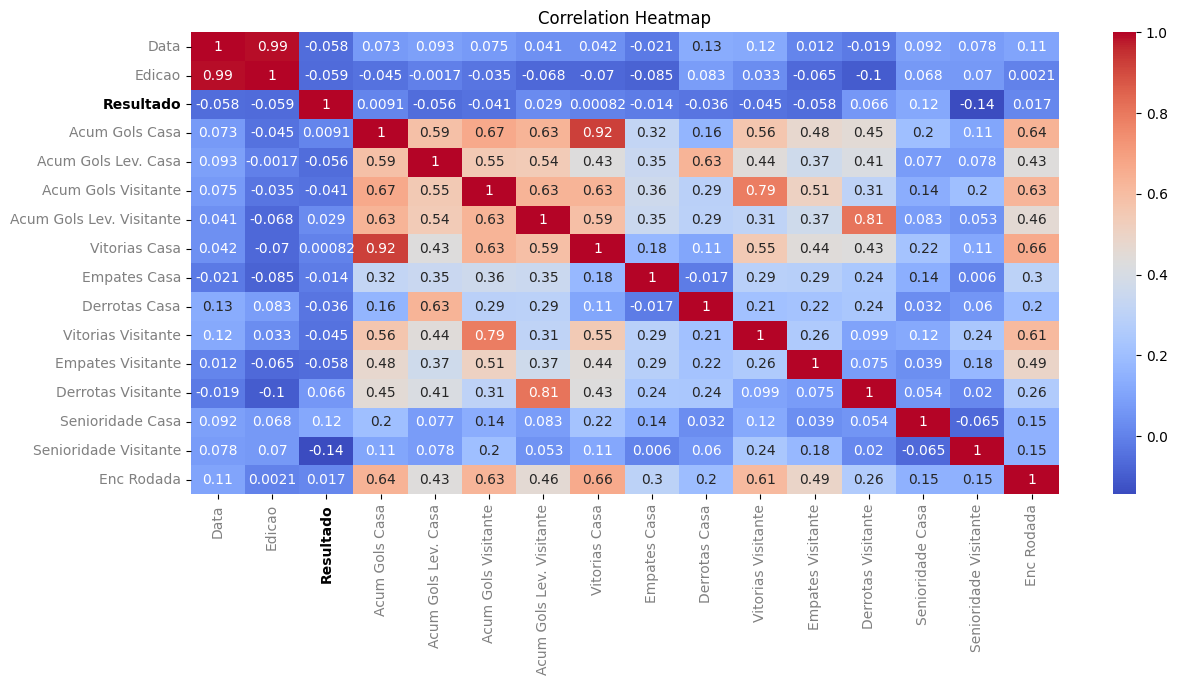

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular a correlação
correlation = train_to_select.corr(method='spearman')

# Cria um gráfico de calor
plt.figure(figsize=(14, 6))
ax = sns.heatmap(correlation, cmap='coolwarm', annot=True)

# Obter os rótulos dos eixos
labels = ax.get_xticklabels() + ax.get_yticklabels()

# Iterar sobre os rótulos e adicionar negrito aos que correspondem a 'Resultado'
for label in labels:
    text = label.get_text()
    if text == 'Resultado':
        label.set_weight('bold')
        label.set_color('black')
    else:
        label.set_weight('normal')
        label.set_color('gray')

plt.title('Correlation Heatmap')
plt.show()

In [37]:
len(Xtrain.columns)

15

---------
### Mas antes, precisamos escalonar os dados, para que todas as variáveis tenham a mesma dimensão e assim nos asseguramos de nos sabotar ao deixar de escolher uma feature por conta da sua dimensão.

In [38]:
Xtrain = Xtrain.drop(columns='Data')

In [39]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().set_output(transform='pandas')
Xtrain_scaled = scaler.fit_transform(Xtrain)

--------

In [40]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [41]:
log_reg = LogisticRegression(penalty='l1', C=0.5, solver='liblinear')
sfm = SelectFromModel(log_reg, max_features=3).fit(Xtrain_scaled, ytrain)
sfm.get_feature_names_out()

array(['Edicao', 'Senioridade Casa', 'Senioridade Visitante'],
      dtype=object)

In [42]:
lsvc = LinearSVC(penalty='l1', C=0.5, dual=False)
sfm = SelectFromModel(log_reg, max_features=3).fit(Xtrain_scaled, ytrain)
sfm.get_feature_names_out()

array(['Edicao', 'Senioridade Casa', 'Senioridade Visitante'],
      dtype=object)

In [43]:
rfc = RandomForestClassifier(max_depth=3, criterion='entropy', n_estimators=80)
sfm = SelectFromModel(rfc, max_features=3).fit(Xtrain_scaled, ytrain)
sfm.get_feature_names_out()
# rfc.fit(Xtrain_scaled, ylabeled)
# pd.DataFrame(rfc.feature_importances_, index=rfc.feature_names_in_).T

array(['Edicao', 'Senioridade Casa', 'Senioridade Visitante'],
      dtype=object)

In [44]:
mapping_xgb_labels = {-1:0, 0:1, 1:2}
ylabeled = ytrain.map(mapping_xgb_labels)

xgb = XGBClassifier(max_depth=3, n_estimators=80, learning_rate=0.1)
sfm = SelectFromModel(xgb, max_features=3).fit(Xtrain_scaled, ylabeled)
sfm.get_feature_names_out()

array(['Vitorias Visitante', 'Senioridade Casa', 'Senioridade Visitante'],
      dtype='<U24')

In [45]:
xgb.fit(Xtrain_scaled, ylabeled)
pd.DataFrame(xgb.feature_importances_, index=xgb.feature_names_in_).T

,Edicao,Acum Gols Casa,Acum Gols Lev. Casa,Acum Gols Visitante,Acum Gols Lev. Visitante,Vitorias Casa,Empates Casa,Derrotas Casa,Vitorias Visitante,Empates Visitante,Derrotas Visitante,Senioridade Casa,Senioridade Visitante,Enc Rodada
0,0.074857,0.070869,0.072017,0.069899,0.071053,0.043604,0.054599,0.060607,0.079757,0.055646,0.066892,0.093692,0.123759,0.062748


#### Vamos seguir com essas variáveis para próxima etapa de construção de modelos.

In [46]:
# features_selecionadas = list(sfm.get_feature_names_out())
features_selecionadas = ['Edicao', 'Acum Gols Visitante', 'Vitorias Visitante', 'Senioridade Casa', 'Senioridade Visitante']

---------
## Aplicando transformações no conjunto de teste também

### 1. Variáveis realcionadas aos gols

In [47]:
test_gols = cria_variaveis_gols(test)

### 2. Cria variáveis de resultados na competição

In [48]:
test_all_feats = cria_variaveis_resultados_competicao(test_gols)

### 3. Número de participações

In [49]:
test_all_feats["Senioridade Casa"] = encoder.transform(test_all_feats["Casa"])
test_all_feats["Senioridade Visitante"] = encoder.transform(test_all_feats["Visitante"])

# e o encoder da rodada
test_all_feats["Enc Rodada"] = test_all_feats["Rodada"].map(encod_rodada)

### 4. Scaler

In [50]:
Xtest = test_all_feats.drop(columns=["Resultado"])
ytest = test_all_feats["Resultado"]

Xtest_scaled = scaler.transform(Xtest[Xtrain.columns])

### 5. Seleção de features

In [51]:
Xtrain_escolhidas = Xtrain[features_selecionadas].merge(train_all_feats[["Casa", "Visitante", "Rodada"]], left_index=True, right_index=True)
Xtest_escolhidas = Xtest[features_selecionadas].merge(test_all_feats[["Casa", "Visitante", "Rodada"]], left_index=True, right_index=True)

--------
## to csv

In [52]:
Xtrain_escolhidas.to_csv('csv/Xtrain.csv', index=False)
ytrain.to_csv('csv/ytrain.csv', index=False)
Xtest_escolhidas.to_csv('csv/Xtest.csv', index=False)
ytest.to_csv('csv/ytest.csv', index=False)

-----
# Aplicando transformações na Libertadores 2023

In [53]:
jogos_futuros = pd.read_csv('csv/jogos_para_prever.csv')

In [54]:
libertadores2023 = df.loc[df["Edicao"] == 2023]

In [55]:
libertadores2023 = pd.concat([libertadores2023, jogos_futuros], axis=0)

In [56]:
libertadores2023 = libertadores2023.drop(columns=['Data', 'Sem'])

In [57]:
# 1. variáveis gols
libertadores2023 = cria_variaveis_gols(libertadores2023)

# 2. resultados na competição
libertadores2023 = cria_variaveis_resultados_competicao(libertadores2023)

# 3. Número de participações 
libertadores2023["Senioridade Casa"] = encoder.transform(libertadores2023["Casa"])
libertadores2023["Senioridade Visitante"] = encoder.transform(libertadores2023["Visitante"])
# e o encoder da rodada
libertadores2023["Enc Rodada"] = libertadores2023["Rodada"].map(encod_rodada)

# 4. Scaler
X_libertadores2023 = libertadores2023.drop(columns=["Resultado"])
y_libertadores2023 = libertadores2023["Resultado"]
X_libertadores2023 = scaler.transform(X_libertadores2023[Xtrain.columns])

# 5. Seleção de features
X_libertadores2023 = X_libertadores2023[features_selecionadas].merge(libertadores2023[["Casa", "Visitante", "Rodada"]], left_index=True, right_index=True)

In [58]:
libertadores2023[(libertadores2023["Casa"] == 'Palmeiras') | (libertadores2023["Visitante"] == 'Palmeiras')]

,Rodada,Edicao,Casa,Visitante,Nacionalidade Casa,Nacionalidade Visitante,Resultado,Gols Casa,Gols Visitante,Acum Gols Casa,...,Acum Gols Lev. Visitante,Vitorias Casa,Empates Casa,Derrotas Casa,Vitorias Visitante,Empates Visitante,Derrotas Visitante,Senioridade Casa,Senioridade Visitante,Enc Rodada
1173,Fase de Grupos,2023,Bolívar,Palmeiras,bo,br,1.0,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0
1191,Fase de Grupos,2023,Palmeiras,Cerro Porteño,br,py,1.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0
1203,Fase de Grupos,2023,Barcelona SC,Palmeiras,ec,br,-1.0,0.0,2.0,2.0,...,3.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,5.0,0
1211,Fase de Grupos,2023,Cerro Porteño,Palmeiras,py,br,-1.0,0.0,3.0,2.0,...,3.0,1.0,0.0,1.0,1.0,0.0,1.0,5.0,5.0,0
1236,Fase de Grupos,2023,Palmeiras,Barcelona SC,br,ec,1.0,4.0,2.0,2.0,...,3.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,3.0,0
1256,Fase de Grupos,2023,Palmeiras,Bolívar,br,bo,1.0,4.0,0.0,6.0,...,2.0,2.0,0.0,0.0,1.0,0.0,1.0,5.0,4.0,0
6,Oitavas de final,2023,Atlético Mineiro,Palmeiras,br,br,NaN,NaN,NaN,4.0,...,3.0,2.0,0.0,1.0,2.0,0.0,1.0,5.0,5.0,1
14,Oitavas de final,2023,Palmeiras,Atlético Mineiro,br,br,NaN,NaN,NaN,10.0,...,3.0,3.0,0.0,0.0,1.0,1.0,1.0,5.0,5.0,1
